In [36]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',dummy_features=['day,hour','month'],features = ['distance','weekend','vappr'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.dummy_features = dummy_features
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                print('fuck')
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(80,80,80,80))
                #self.features = [f for f in self.features \
                #                if f[0:4]!='hour']
                
 

    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        if self.use_dummies:
            self.add_dummies()
            self.features += self.dummy_features
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep']        
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['base_time_dep']//3600
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=self.dummy_features)
        if 'day' in self.dummy_features:
            features = [f for f in self.data.columns if f != 'dayofservice']
        else:
            features = self.data.columns
        new_features = []
        for f in features:
            for f2 in self.dummy_features:
                if f[0:len(f2)] != f2:
                    new_features.append(f)
        self.dummy_features = new_features


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [37]:
r=BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids


MemoryError: 

In [ ]:
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.preprocessing import normalize
#r.features = [f for f in r.features if f[0:4]!='hour']

In [5]:
r.features

NameError: name 'r' is not defined

In [ ]:
import numpy as np
train = r.data[r.data['year']==2016]
train_X = train[r.features]
train_Y = np.array([i for i in train['traveltime']]).reshape(-1,1)
transformer1 = mms().fit(train_X)
transformer2=mms().fit(train_Y)
train_X = normalize(train_X)
train_Y = transformer2.transform(train_Y)

In [6]:
test = r.data[r.data['year']==2017]
test = test[test['distance']==test['distance'].max()]
real_traveltimes = test['traveltime']
test_X = test[r.features]
test_Y = np.array([i for i in test['traveltime']]).reshape(-1,1)
test_X = normalize(test_X)
test_Y = transformer2.transform(test_Y)

In [ ]:
model = r.rgr.fit(train_X,train_Y)

In [8]:
preds = model.predict(test_X)
from sklearn import metrics
print(metrics.r2_score(test_Y,preds))
print(((abs(test_Y-preds)/test_Y)*100).mean())

0.5151850256256976
10.894408494083756


In [9]:

reals = transformer2.inverse_transform(preds.reshape(-1,1))
reals1 = np.array([i[0] for i in reals])

In [94]:
reals1

array([3126.71852357, 3126.71852357, 3126.71852357, ..., 5237.67983712,
       3706.60685987, 5093.79734799])

In [10]:
print(metrics.r2_score(real_traveltimes,reals))
print(((abs(real_traveltimes-reals1)/real_traveltimes)*100).mean())

0.5151850256256976
8.52236487873557


# Why does the percentage change?

# This model seems valid. The data is minMax scaled rather than normalized (normalization seems funny). 

# No information is included that wouldn't be known at the time of departure from the first stop.

### It's metrics aren't great. If they will do, or not, we can't really be sure. Can still experiment with more layers, more features etc. But otherwise, this one is done. All that's left is to, I guess, plot it out in some form or other.

## I would be interested though as to how normalization had such a good effect on the results

In [96]:
test = r.data[r.data['year']==2017]

real_traveltimes = test['traveltime']
test_X = test[r.features]
test_Y = np.array([i for i in test['traveltime']]).reshape(-1,1)
test_X = transformer1.transform(test_X)
test_Y = transformer2.transform(test_Y)

In [97]:
preds = model.predict(test_X)
from sklearn import metrics
print(metrics.r2_score(test_Y,preds))


0.9570079633096892


MemoryError: 

In [98]:
print(((abs(test_Y-preds)/test_Y)*100).mean())

MemoryError: 

In [16]:
try:
    del(train)
    del(train_X)
    del(train_Y)
    del(test_X)
    del(test_Y)
except:
    pass
t = r.data[r.data['year']==2017]
distances = []
r2s = []
mape = []
travel_time = []
distances = sorted(t['distance'].unique())
for i in range(1, len(distances)-1):
    test = t[(t['distance']>=distances[i])&(t['distance']<=distances[i+1])]
    real_traveltimes = test['traveltime']
    test_X = test[r.features]
    test_Y = np.array([i for i in test['traveltime']]).reshape(-1,1)
    test_X = transformer1.transform(test_X)
    test_Y = transformer2.transform(test_Y)
    travel_time.append(test['traveltime'].mean())
    preds = model.predict(test_X)
    from sklearn import metrics
    r2s.append(metrics.r2_score(test_Y,preds))
    reals = np.array([i[0] for i in transformer2.inverse_transform(preds.reshape(-1,1))])
    m=((abs(real_traveltimes-reals)/real_traveltimes)*100).mean()
    mape.append(m)
    
    
    

In [12]:
mape

[inf,
 38.401827873792946,
 32.670604499746375,
 27.22174305684288,
 16.941678420662008,
 16.24329675182506,
 15.501187950971811,
 14.421212042750781,
 13.383573763944701,
 13.048955682700608,
 12.683752110926452,
 12.213448061588082,
 12.028336484059396,
 11.868891390518028,
 11.685569747381573,
 11.502995880416805,
 11.277083074960947,
 11.133170037058392,
 11.01067334999916,
 10.881058997320107,
 10.703437565491537,
 10.484268121097434,
 10.44491486394732,
 10.44256141801435,
 10.308088562108281,
 10.312802695650873,
 10.324062084877367,
 10.362339971707613,
 10.449940082231905,
 10.59326872938594,
 10.755525098096024,
 11.734032727581598,
 10.796315937327464,
 10.527899685786148,
 10.052814157516385,
 9.684868122894043,
 9.453597868519067,
 9.336715235786334,
 9.314868230893163,
 9.306909455669125,
 9.283553155130104,
 9.212350388711002,
 9.149325624247464,
 9.09236044363792,
 9.010644215806797,
 8.9615759670778,
 8.951862967495778,
 8.9577653348609,
 8.943200417829956,
 8.92203915

In [9]:
r2s

[-0.6851637006155753,
 -0.08053161134879261,
 -0.5197370980361731,
 -0.193799174818734,
 -0.12368877678676182,
 0.017983702739426843,
 0.052773830539577515,
 0.07219783542288727,
 0.1919723484541218,
 0.2140320764160043,
 0.27109280328818375,
 0.28478159208554554,
 0.2872930139719029,
 0.32129454313279393,
 0.3345195270535607,
 0.35114146728575757,
 0.3622470753313084,
 0.38253072721923453,
 0.38503633509244206,
 0.3922295483706474,
 0.3966832986677149,
 0.40386999054183403,
 0.41161993192239354,
 0.41122174624766417,
 0.4181052432836406,
 0.4278794477083001,
 0.4361612501688943,
 0.43835139518477384,
 0.42538990451145653,
 0.4196381517608764,
 0.404030709278997,
 0.31365305765507945,
 0.35639772073329923,
 0.3684286148699648,
 0.3676430216354858,
 0.3754901450876732,
 0.3976639694142641,
 0.39920686494621915,
 0.4056753129318095,
 0.41468140956819943,
 0.4198882831392976,
 0.4246040521378376,
 0.4229850717568665,
 0.42216015578135513,
 0.4319931744947002,
 0.43753659803788647,
 0.4396

In [14]:
from matplotlib import pyplot as plt

In [11]:
len(distances)

69

In [12]:
len(r2s)

67

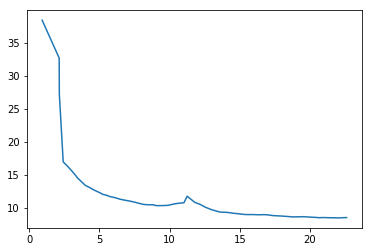

In [15]:
plt.plot(distances[2:],mape)

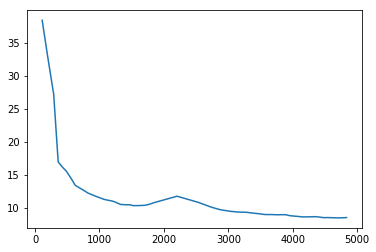

In [18]:
plt.plot(travel_time,mape)

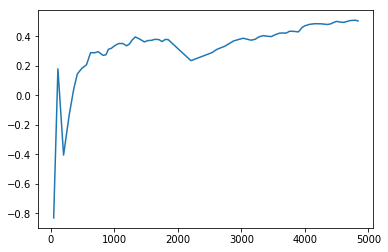

In [19]:
plt.plot(travel_time,r2s)
plt.xlabel('Travel time')
plt.ylabel('R**2 score')

## There is a pretty significant decrease in MAPE around the 3km mark. What if we try to model that individually

In [1]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['hour','month','day','distance','weekend','rhum','vappr'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                print('fuck')
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(80,80,80,80))
                #self.features = [f for f in self.features \
                #                if f[0:4]!='hour']
                
 

    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        #if self.use_dummies:
        #    self.add_dummies()
        #    self.features += self.dummy_features
        #self.data = self.data[self.data['distance']<5]
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep']        
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['base_time_dep']//3600
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['day','month','hour'])
        self.dummy_features = [col for col in self.data.columns\
                                if (col[0:3] == 'day' and col != 'dayofservice')\
                                or col[0:5] == 'month' or col[0:4] == 'hour']


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [2]:
r=BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather


In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.preprocessing import Normalizer
train = r.data[r.data['year']==2016]
train_X = train[r.features]
train_Y = np.array([i for i in train['traveltime']]).reshape(-1,1)
transformer1 = mms().fit(train_X)
transformer2=mms().fit(train_Y)
train_X = transformer1.transform(train_X)
train_Y = transformer2.transform(train_Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.preprocessing import normalize
#r.features = [f for f in r.features if f[0:4]!='hour']

In [10]:
model = r.rgr.fit(train_X,train_Y)

/home/student/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
test = r.data[r.data['year']==2017]

real_traveltimes = test['traveltime']
test_X = test[r.features]
#test_Y = np.array([i for i in test['traveltime']]).reshape(-1,1)
#test_X = transformer1.transform(test_X)
#test_Y = transformer2.transform(test_Y)

In [ ]:
preds = model.predict(test_X)
from sklearn import metrics
print(metrics.r2_score(test_Y,preds))


In [22]:
test_X.columns

Index(['hour', 'month', 'day', 'distance', 'weekend', 'rhum', 'vappr'], dtype='object')

In [11]:
distances = []
preds=[]
curr_distance = 0.05
X = test_X.sample()
print(X['distance'])
X['distance']=0.05

to_concat = []
while curr_distance < 20:
    X['distance']+= curr_distance
    print(X['distance'])
    curr_distance += 0.05
    to_concat.append(X)
    distances.append(curr_distance)
X = pd.concat(to_concat,axis=0)
X = transformer1.transform(X)
preds = model.predict(X)

    


AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [23]:
preds

array([38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09474112,
       38.09474112, 38.09474112, 38.09474112, 38.09474112, 38.09

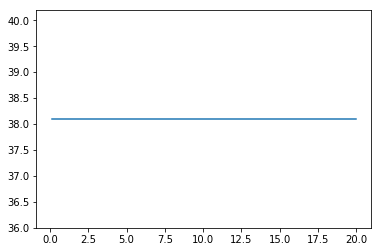

In [21]:
from matplotlib import pyplot as plt
plt.plot(distances,preds)

In [12]:
try:
    del(train)
    del(train_X)
    del(train_Y)
    del(test_X)
    del(test_Y)
except:
    pass
t = r.data[r.data['year']==2017]
distances = []
r2s = []
mape = []
travel_time = []
distances = sorted(t['distance'].unique())
for i in range(0, len(distances)-1):
    test = t[(t['distance']>=distances[i])&(t['distance']<=distances[i+1])]
    real_traveltimes = test['traveltime']
    test_X = test[r.features]
    test_Y = np.array([i for i in test['traveltime']]).reshape(-1,1)
    test_X = transformer1.transform(test_X)
    test_Y = transformer2.transform(test_Y)
    travel_time.append(test['traveltime'].mean())
    preds = model.predict(test_X)
   
    from sklearn import metrics
    r2s.append(metrics.r2_score(test_Y,preds))
    reals = np.array([i[0] for i in transformer2.inverse_transform(preds.reshape(-1,1))])
    print(reals.mean())
    m=((abs(real_traveltimes-reals)/real_traveltimes)*100).mean()
    mape.append(m)
    
    
    

32.93343880534083
51.01230517488186
89.6706786224197
214.66214956615306
312.2613326422258
338.48123324463455
394.48135089540267
455.4573612779126
525.8318723566415
615.9776454734031
695.2220435514275
753.2407673491105
825.340119675416
882.7702591539851
924.0494337448738
970.4743812114061
1023.8542218701233
1087.4935767074505
1146.3324421635161
1203.4522682182737
1256.0142368958543
1308.2464293571427
1372.5955859879382
1437.8381014753948
1497.7698831977193
1555.6909626289803
1610.3055055505565
1668.2627259415199
1730.5151664421414
1783.835361627514
1855.1872981036174
1919.1434310050843
2248.478200844775
2574.3114422781737
2657.884545023916
2825.968665951199
3004.999690905323
3147.875534054949
3228.694847363796
3280.060383566487
3320.5638868218502
3352.8096448387073
3395.378343164292
3442.377834380044
3495.5779186471673
3561.9712545352104
3619.873495880706
3672.193850552262
3721.3629312345984
3758.3686662165255
3807.206607933762
3863.266751343825
3916.3907497929436
3968.560231142396
4012

In [18]:
mape

[inf,
 inf,
 43.08393659333414,
 37.0210803246662,
 28.148994255507606,
 18.518346118947647,
 16.81564931423976,
 16.016103255117336,
 15.196169722990112,
 14.078889347191472,
 13.87308304928848,
 13.55680810302214,
 13.014626307736856,
 12.903086683964782,
 12.748797395866239,
 12.455844708997944,
 12.240603742829254,
 12.081133317127495,
 11.723499597955538,
 11.433580496735111,
 11.452303365951275,
 11.586703733580961,
 11.588525089175405,
 11.282558136960635,
 11.075511043215764,
 10.995531106281804,
 10.943431807508215,
 10.996336941981058,
 11.077391643591875,
 11.286142623911774,
 11.795467388306388,
 12.240288845217156,
 12.500503913404714,
 10.897923757796713,
 10.850194787727935,
 10.976808279090125,
 11.228171223467857,
 10.805150271411081,
 10.126099646383492,
 9.968502452125923,
 9.985397340959395,
 9.94556641186861,
 9.847312549502279,
 9.674708003319505,
 9.546659481762724,
 9.514741733902389,
 9.528139725467476,
 9.59093632203081,
 9.542762972289907,
 9.458216328676684,

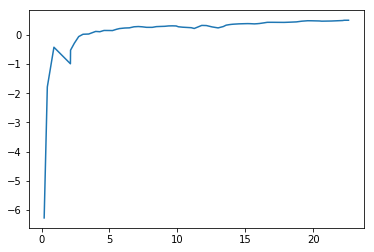

In [13]:
from matplotlib import pyplot as plt
plt.plot(distances[1:],r2s)
plt.show()

In [1]:
from matplotlib import pyplot as plt
plt.plot(distances[1:],mape)
plt.show()
plt.xlabel('Distance')
plt.ylabel('MAPE')

NameError: name 'distances' is not defined

In [69]:
mape

[inf,
 inf,
 41.60142434331016,
 34.88248625192814,
 31.385243341900413,
 16.61989213097956,
 15.766133737274531,
 14.7160563854273,
 13.938383709814413,
 14.000521209765697,
 14.472786418174968,
 13.634232061485283,
 12.688635585535632,
 12.675197774627621,
 12.474135270063679,
 12.125854028641621,
 11.891209468758955,
 11.72433573069584,
 11.407386137098483,
 11.126140047634285,
 11.11244930831723,
 11.232247791074583,
 11.230087972597113,
 10.88180696873555,
 10.653699696501443,
 10.569534735996616,
 10.509270377784018,
 10.560715258282025,
 10.600195064260957,
 10.762874521084614,
 11.23426101136007,
 11.65684208440838,
 12.0850563180674,
 10.84371697609378,
 10.693829276289755,
 10.500687437787102,
 10.39369742230823,
 10.05014078124156,
 9.703859743834327,
 9.679170653521574,
 9.741134739725211,
 9.735035555503202,
 9.678486470336109,
 9.563563732616114,
 9.48119555144593,
 9.453978569374815,
 9.436110110540218,
 9.450139179002377,
 9.42001525884085,
 9.369318113896922,
 9.337633

# Its really only the first part of the route where the values are rubbish

In [27]:
r.features

['distance',
 'weekend',
 'vappr',
 'day_0',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23']

# Test again, with stopA, stopB instead of distance

In [72]:
from dbanalysis import stop_tools
import pandas as pd
class BRModel():
    """
    Big route model class
    uses the distance of a stop from first stop on a route to compute predictions lalalala
    MAPE and r2 scores are not as good as they were in the notebook
    (we achieved 0.57 r2, and 7% MAPE on the time to complete the route)
    Should look into this.
    """
    def __init__ (self, route,variation,verbose=True,src='build',rgr='RandomForest',\
                mode='validate',features = ['hour','month','day','weekend','rhum','vappr'],use_dummies=True):
        
        import json
        self.regr_type = rgr
        self.verbose = verbose
        self.route = route
        self.use_dummies = use_dummies
        self.variation = variation
        self.routes = json.loads(open('/home/student/dbanalysis/dbanalysis/resources/trimmed_routes.json').read())
        self.features = features
        self.route_array = self.routes[route][variation][1:]
        del(self.routes)
        if src == 'build':
            if not self.can_be_modelled():
                print('fuck')
                raise ValueError ('Missing data for modelling this route')

            self.gather_data()
            self.preprocess()
            if rgr == 'RandomForest':
                from sklearn.ensemble import RandomForestRegressor as rf
                self.rgr = rf()
            elif rgr == 'Linear':
                from sklearn.linear_model import LinearRegression as lr
                self.rgr = lr(fit_intercept=True)
            elif rgr == 'Neural':
                from sklearn.neural_network import MLPRegressor as mlpr
                self.rgr = mlpr(hidden_layer_sizes=(80,80,80,80))
                #self.features = [f for f in self.features \
                #                if f[0:4]!='hour']
                
 

    def gather_data(self):
        if self.verbose:
            print('gathering data...')
        from dbanalysis import stop_tools
        arr = self.route_array
        import os
        to_concat = []
        for i in range(len(arr)-1):
            
            data = stop_tools.get_stop_link(arr[i],arr[i+1])
            to_concat.append(data)
            del(data)
        self.data = pd.concat(to_concat,axis=0)
        del to_concat
        

    def preprocess(self):
        if self.verbose:
            print('Preprocessing data')
        self.select_routes()
        self.clean_1()
        self.add_distances()
        self.add_base_departure_time()
        self.add_time_info()
        
        self.merge_weather()
        if self.use_dummies:
            self.add_dummies()
            self.features += self.dummy_features
        #self.data = self.data[self.data['distance']<5]
    def select_routes(self):
        if self.verbose:
            print('parsing routeids')
        routeids = self.data['routeid'].unique()
        valid_routeids = [r for r in routeids if r.split('_')[0] == self.route]
        self.data = self.data[self.data['routeid'].isin(valid_routeids)]
    def clean_1(self):
        if self.verbose:
            print('dropping null values')
        self.data = self.data.dropna()
        
    def add_distances(self):
        if self.verbose:
            print('adding distances')
        s_getter =stop_tools.stop_getter()
        total_distance = 0
        r = self.route_array
        route_distances = {r[0]:0}
        
        for i in range(0, len(r)-1):
            distance = s_getter.get_stop_distance(str(r[i]),str(r[i+1]))
                
            total_distance += distance
            route_distances[r[i+1]]=total_distance
        self.data['distance']=self.data['stopA'].apply(lambda x: route_distances[x])
        del(s_getter)
    def add_base_departure_time(self):
        if self.verbose:
            print('adding base departure times')
       
        keys= self.data[self.data['stopA']==self.route_array[0]]
        keys['base_time_dep']=keys['actualtime_arr_from']
        keys2=keys[['tripid','dayofservice','base_time_dep']]
        self.data = pd.merge(self.data,keys2,on=['dayofservice','tripid'])
        
        self.data['traveltime']=self.data['actualtime_arr_from']-self.data['base_time_dep']        
        del(keys)
        del(keys2)
    
    def add_time_info(self):
        if self.verbose:
            print('adding time information')
        time_format = "%d-%b-%y %H:%M:%S"
        self.data['dt']=pd.to_datetime(self.data['dayofservice'],format=time_format)
        self.data['day']=self.data['dt'].dt.dayofweek
        self.data['month']=self.data['dt'].dt.month
        self.data['hour'] = self.data['base_time_dep']//3600
        self.data['weekend']=self.data['day']>4
        self.data['year']=self.data['dt'].dt.year
        self.data['date'] = self.data['dt'].dt.date
    def merge_weather(self,weather=None):
        if self.verbose:
            print('merging weather')
        if weather == None:
          
            weather = pd.read_csv('/home/student/dbanalysis/dbanalysis/resources/cleanweather.csv').dropna()
        weather['dt']=pd.to_datetime(weather['date'])
        weather['hour']=weather['dt'].dt.hour
        weather['date']=weather['dt'].dt.date
        
        self.data = pd.merge(self.data,weather,on=['date','hour'])
        del(weather)

    def add_dummies(self):
        if self.verbose:
            print('Making dummy features')
        self.data = pd.get_dummies(self.data,columns=['stopA','stopB'])
        self.dummy_features = [col for col in self.data.columns\
                               if col[0:4]=='stop']


    def can_be_modelled(self):
        if self.verbose:
            print('Checking for data files')
        import os
        base_dir = '/data/stops/'
        arr = self.route_array
        for i in range(len(arr)-1):
            
            if os.path.exists(base_dir+str(arr[i])+'/'+str(arr[i+1])+'.csv'):
                pass
            else:
                print('broken')
                input()
                return False
        return True


In [70]:
r.data.columns

Index(['index', 'dayofservice', 'tripid', 'plannedtime_arr_from',
       'plannedtime_dep_from', 'actualtime_arr_from', 'actualtime_dep_from',
       'plannedtime_arr_to', 'actualtime_arr_to', 'routeid', 'stopA', 'stopB',
       'distance', 'base_time_dep', 'traveltime', 'dt_x', 'day', 'month',
       'hour', 'weekend', 'year', 'date', 'dewpt', 'msl', 'rain', 'rhum',
       'temp', 'vappr', 'wetb', 'dt_y'],
      dtype='object')

In [73]:
r=BRModel('15',1,rgr='Neural')

Checking for data files
gathering data...
Preprocessing data
parsing routeids
dropping null values
adding distances
adding base departure times


/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


adding time information
merging weather
Making dummy features


NameError: name 'train_X' is not defined

In [78]:
import numpy as np
train = r.data[r.data['year']==2016]
train_X = train[r.features]
train_Y = np.array([i for i in train['traveltime']]).reshape(-1,1)
transformer1 = mms().fit(train_X)
transformer2=mms().fit(train_Y)
train_X = normalize(train_X)
train_Y = transformer2.transform(train_Y)

MemoryError: 

# Ok. This approach seemingly just means memory error to us

In [76]:
model = r.rgr.fit(train_X,train_Y)

MemoryError: 

In [ ]:
try:
    del(train)
    del(train_X)
    del(train_Y)
    del(test_X)
    del(test_Y)
except:
    pass
t = r.data[r.data['year']==2017]
distances = []
r2s = []
mape = []
travel_time = []
stops = t['stopA'].unique()
for stopA in stops
    test = t[t['stopA']==stopA]
    real_traveltimes = test['traveltime']
    test_X = test[r.features]
    test_Y = np.array([i for i in test['traveltime']]).reshape(-1,1)
    test_X = transformer1.transform(test_X)
    test_Y = transformer2.transform(test_Y)
    travel_time.append(test['traveltime'].mean())
    preds = model.predict(test_X)
    from sklearn import metrics
    r2s.append(metrics.r2_score(test_Y,preds))
    reals = np.array([i[0] for i in transformer2.inverse_transform(preds.reshape(-1,1))])
    m=((abs(real_traveltimes-reals)/real_traveltimes)*100).mean()
    mape.append(m)
    
    
    

In [ ]:
So... Just changing features